In [58]:
from smartem.segmentation import segmenter, utils
from skimage import measure
from smartem.offline.train_mb_error_detector.NNtools import UNet
from smartem.online.models import UNet as UNet_online
import h5py
import matplotlib.pyplot as plt
import torch
import numpy as np
# import pyvoi
import pandas as pd

import seaborn as sns
import cv2
import os
import random
import tqdm
import segmentation_models_pytorch as smp

from scipy.ndimage import binary_dilation

In [23]:
import importlib
import smartem.segmentation.segmenter
importlib.reload(smartem.segmentation.segmenter)
from smartem.segmentation import segmenter, utils

In [4]:
device = torch.device("cuda:5")

In [10]:
model = UNet_online.UNet(1, 2)
model_path = (
    "/home/ssawmya-local/FM_work/SmartEM/pretrained_models/em2mb_best_core.pth"
)

# ENCODER = 'mit_b5'
# ENCODER_WEIGHTS = 'imagenet'
# CLASSES = [1,2]
# ACTIVATION = "sigmoid"

# model = smp.Unet(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=len(CLASSES), 
#     activation=ACTIVATION,
# )
# # model = 
# model_path = (
#      "/home/ssawmya-local/FM_work/SmartEM/pretrained_models/best_model_b5.pth"
# )

In [24]:
Iseg = segmenter.Segmenter(model_path, segmenter_function=measure.label, device=device)
Iseg.set_model(model_class=model)

In [38]:
images_path_30x30_section = "/storage/projects/smartEM/30x30_one_section/0001"
membrane_path_30x30_one_section = "/storage/projects/smartEM/30x30_one_section/membranes"
cbex_path_30x30_one_section = "/storage/projects/smartEM/30x30_one_section/cbex"
synapse_path_30x30_one_section = "/storage/projects/smartEM/30x30_one_section/synapse"


In [26]:


# Get a list of all file names in the directory
file_names = os.listdir(images_path_30x30_section)
idx = 0
for file_name in tqdm.tqdm(file_names):
    file_path = os.path.join(images_path_30x30_section, file_name)
    # Load the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    # image_without_clahe = image
    clahe = cv2.createCLAHE(clipLimit=255 * 3.0).apply
    image = clahe(image)


    
    # get membrane probabilities
    membrane = Iseg.get_membranes(image, get_probs = True, threshold = 0.5, for_smp=False)[0]
    # membrane_without_clahe = Iseg.get_membranes(image_without_clahe, get_probs = True, threshold = 0.5)[0]
    # plt.imshow(membrabe)
    # idx += 1
    # if idx == 5:
    #     # plt.imshow(membrane, cmap = 'gray')
    #     # show the image, membrane and membrane_without_clahe in subplots
    #     fig, ax = plt.subplots(1, 4, figsize = (20, 5))
    #     ax[0].imshow(image_without_clahe, cmap = 'gray')
    #     ax[0].set_title('Image without clahe')
    #     ax[0].set_axis_off()
        
    #     ax[1].imshow(membrane_without_clahe, cmap = 'gray')
    #     ax[1].set_title('Membrane without Clahe')
    #     ax[1].set_axis_off()

    #     ax[2].imshow(image, cmap = 'gray')
    #     ax[2].set_title('Image with clahe')
    #     ax[2].set_axis_off()

    #     ax[3].imshow(membrane, cmap = 'gray')
    #     ax[3].set_title('Membrane with Clahe')
    #     ax[3].set_axis_off()

    #     plt.show()
    #     break
    

    
    # print(membrane_probs.shape)
    # break
    #save the membranes as the same name as file
    membrane_file_path = os.path.join(membrane_path_30x30_one_section, file_name)
    cv2.imwrite(membrane_file_path, membrane)



# Construct the full file path


# load one image from the images_path


100%|██████████| 550/550 [05:20<00:00,  1.72it/s]


uint8


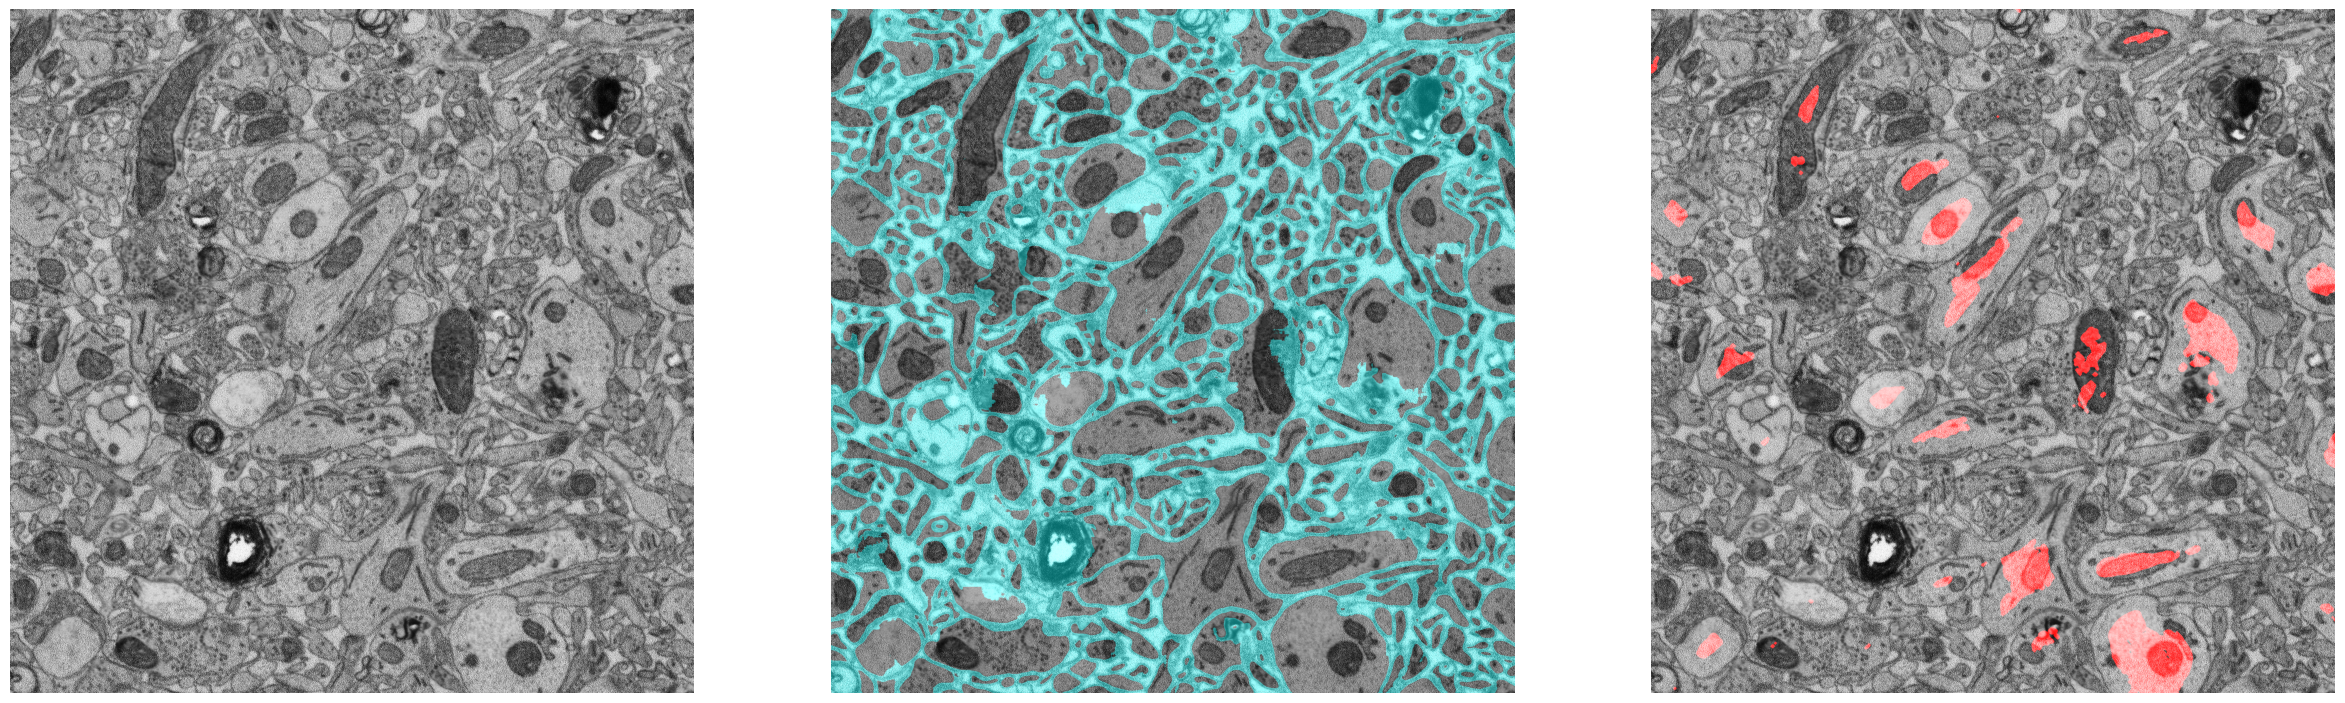

In [76]:
def load_and_overlay_images(image_folder, mask_folder, cbex_folder):
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]  # Adjust the extension if needed

    for idx, filename in enumerate(image_files):
        # continue for everything except for idx > 10 and idx < 20
        # if idx < 10 or idx > 20:
        #     continue
        if idx != 10:
            continue
        # if filename != "0001_tr2-tc5.png":
        #     continue
        image_path = os.path.join(image_folder, filename)
        mask_path = os.path.join(mask_folder, filename)
        cbex_path = os.path.join(cbex_folder, filename)
        # cbex_path = os.path.join)

        # Read the image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        cbex = cv2.imread(cbex_path, cv2.IMREAD_GRAYSCALE)
        print(cbex.dtype)
        cbex = (binary_dilation(cbex, iterations=4)*255).astype(np.uint8)
        # print(cbex.dtype)
        # convert to uint8


        # Check if mask needs to be in color (e.g., if it's not binary or if color is needed for visualization)
        mask_colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        mask_colored[mask == 255] = [0, 255, 255]  # Change color to green; adjust color as needed

        cbex_colored = cv2.cvtColor(cbex, cv2.COLOR_GRAY2RGB)
        cbex_colored[cbex == 255] = [255, 0, 0]

        # Overlay the mask on the image
        overlay = cv2.addWeighted(image, 0.8, mask_colored, 0.4, 0)
        overlay_cbex = cv2.addWeighted(image, 1, cbex_colored, 1, 0)

        # display the two overlays in subplots
        fig, ax = plt.subplots(1, 3, figsize = (30, 10))
        ax[0].imshow(image)
        # ax[0].set_title('Image')
        ax[0].set_axis_off()
        ax[1].imshow(overlay)
        # ax[0].set_title('Overlay of membrane')
        ax[1].set_axis_off()

        ax[2].imshow(overlay_cbex)
        # ax[1].set_title('Overlay of cbex')
        ax[2].set_axis_off()


        # Display the overlay
        # plt.figure(figsize=(10, 10))
        # plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        # plt.title(f"Overlay of {filename}")
        # plt.axis('off')
        # plt.show()

        return image, membrane, cbex


image, membrane, cbex = load_and_overlay_images(images_path_30x30_section, membrane_path_30x30_one_section, cbex_path_30x30_one_section)





In [ ]:
image_files = [f for f in os.listdir(images_path_30x30_section) if f.endswith('.png')]

for file in image_files:
    image_path = os.path.join(images_path_30x30_section, file)
    membrane_path = os.path.join(membrane_path_30x30_one_section, file)
    # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    membrane = cv2.imread(membrane_path, cv2.IMREAD_GRAYSCALE)
    

    plt.imshow(membrane)
    plt.show()

    

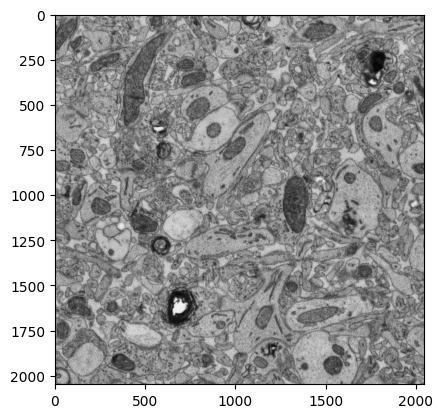

In [77]:
plt.imshow(image)

In [47]:
from connectomics.model.arch import UNet2D,UNetPlus2D


2024-05-12 13:03:37.024203: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-12 13:03:37.136298: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 13:03:37.136350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 13:03:37.151446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-12 13:03:37.189470: I tensorflow/core/platform/cpu_feature_guar

In [73]:
model_synapse_path = "/home/ssawmya-local/FM_work/EMINCLUDE_XCLUDE/SynapseDetection/checkpoint_all/checkpoint_combined.pth"
model_synapse = UNetPlus2D(in_channel=1, out_channel=2)
Iseg_synapse = segmenter.Segmenter(model_synapse_path, segmenter_function=measure.label, device=device)
Iseg_synapse.set_model(model_synapse)


100%|██████████| 550/550 [00:00<00:00, 877.37it/s]


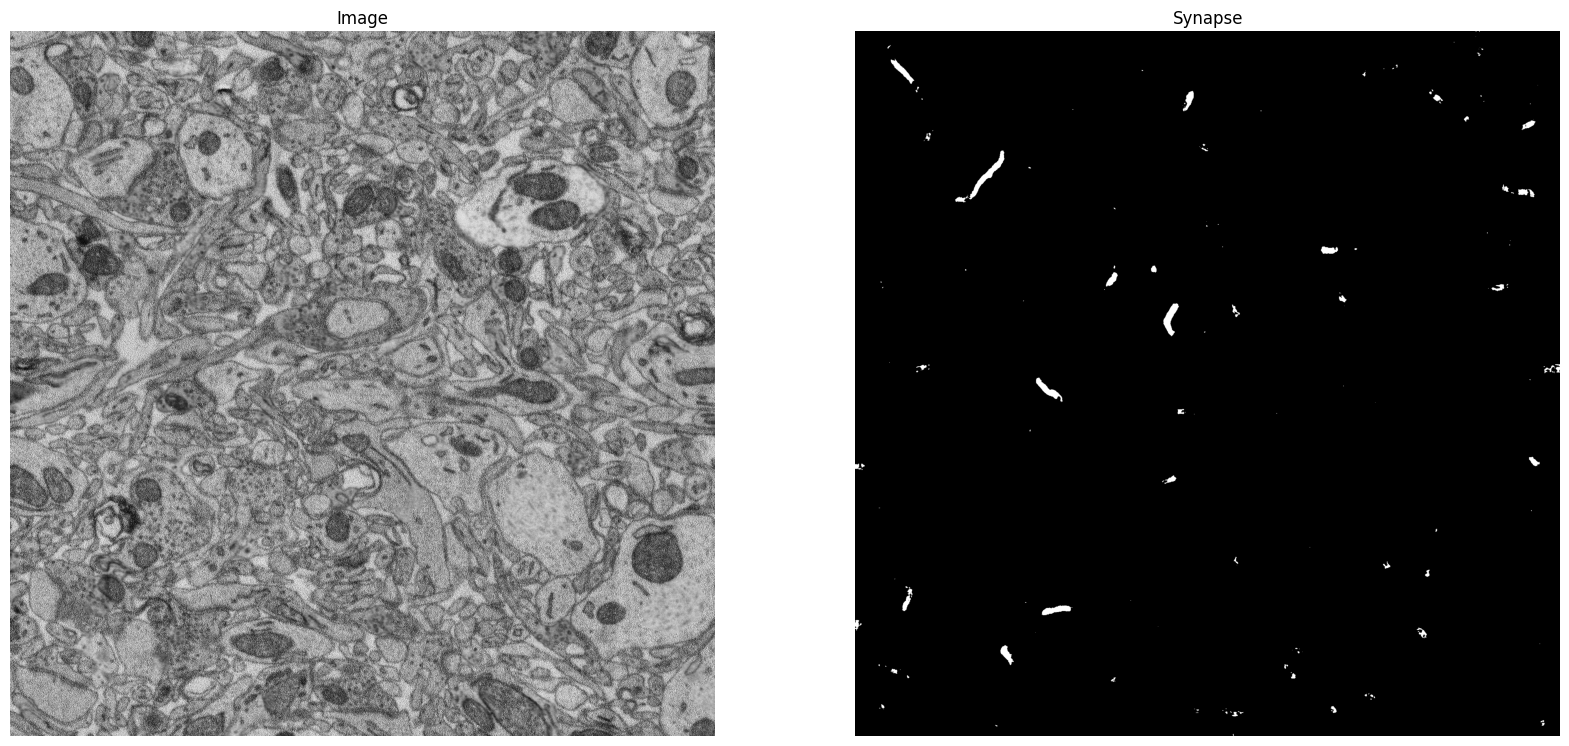

In [79]:
file_names = os.listdir(images_path_30x30_section)
synapse_path_30x30_one_section = "/storage/projects/smartEM/30x30_one_section/synapse"
idx = 0
for file_name in tqdm.tqdm(file_names):
    idx += 1
    if idx != 10:
        continue
    file_path = os.path.join(images_path_30x30_section, file_name)
    # Load the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    # clahe = cv2.createCLAHE(clipLimit=255 * 3.0).apply
    # image = clahe(image)
    
    # get membrane probabilities
    synapse = Iseg_synapse.get_membranes(image, get_probs = False, threshold = 0.6)
    # plt.imshow(synapse, cmap = 'gray')
    # show image and synapse in subplots
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    ax[0].imshow(image, cmap = 'gray')
    ax[0].set_title('Image')
    ax[0].set_axis_off()

    ax[1].imshow(synapse, cmap = 'gray')
    ax[1].set_title('Synapse')
    ax[1].set_axis_off()
    
    
    # print(membrane_probs.shape)
    # break
    #save the membranes as the same name as file
    # synapse_file_path = os.path.join(synapse_path_30x30_one_section, file_name)
    # cv2.imwrite(synapse_file_path, synapse)

In [51]:
model_cbex_path = "/home/ssawmya-local/FM_work/EMINCLUDE_XCLUDE/MustExcludeRegionCodeModels/checkpoint_all_/checkpoint_BCE_all_newdata.pth"
model_cbex = UNetPlus2D(in_channel=1, out_channel=2)
Iseg_cbex = segmenter.Segmenter(model_cbex_path, segmenter_function=measure.label, device=torch.device("cuda:4"))
Iseg_cbex.set_model(model_cbex)

cbex_path_30x30_one_section = "/storage/projects/smartEM/30x30_one_section/cbex"
idx = 0
for file_name in tqdm.tqdm(file_names):
    idx += 1
    # if file_name != "0001_tr2-tc5.png":
    #     continue
    file_path = os.path.join(images_path_30x30_section, file_name)
    # Load the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=255 * 3.0).apply
    image = clahe(image)
    
    # get membrane probabilities
    cbex_prediction = Iseg_cbex.get_membranes(image, get_probs = False)
    
    # print(membrane_probs.shape)
    # break
    #save the membranes as the same name as file
    cbex_file_path = os.path.join(cbex_path_30x30_one_section, file_name)
    cv2.imwrite(cbex_file_path, cbex_prediction)

100%|██████████| 550/550 [03:53<00:00,  2.35it/s]


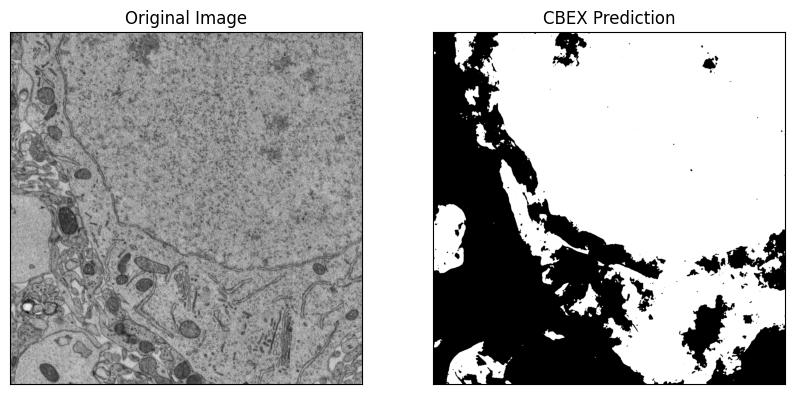

In [42]:
file_path = os.path.join(images_path_30x30_section, "0001_tr2-tc5.png")
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
cbex_prediction = Iseg_cbex.get_membranes(image)
# plt.imshow(cbex_prediction cmap = 'gray')
# show image and cbex_prediction in subplots
# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image in the first subplot
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')

# Display the prediction in the second subplot
axs[1].imshow(cbex_prediction, cmap='gray')
axs[1].set_title('CBEX Prediction')

# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

(-0.5, 2047.5, 2047.5, -0.5)

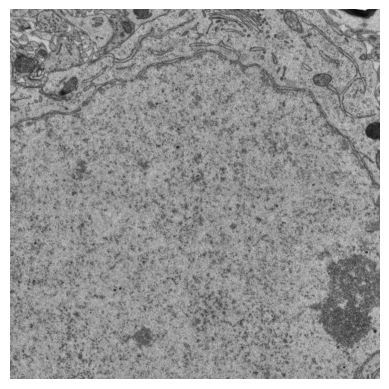

In [6]:
plt.imshow(image, cmap = 'gray')
plt.axis('off')